## 机器学习部分

需要考虑各种单独的模型的各自表现后，筛选出表现较好的模型，并进行集成学习

1.线性回归类模型

    1.1朴素线性回归
    
    1.2基于L1的线性回归
    
    1.3基于L2的线性回归
    
    1.4ElasticNet
    
2.树回归-CART

    2.1CART
    
    2.2RF
    
    2.3AdaBoost
    
    2.4GBDT--XGBoost--lightGBM
    
3.SVM类型

    3.1SVR
    
* 4.神经网络

    4.1FC神经网络
    

5.集成学习

    5.1 Stacking Ensemble

### 数据集的准备

In [11]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split

In [12]:
train=pd.read_csv('./data/train_1.csv')

In [13]:
y=train['SalePrice']

In [14]:
train1=train.drop(['Id','SalePrice'],axis=1)

In [15]:
X=pd.get_dummies(train1).reset_index(drop=True)

In [16]:
X['Unnamed: 0']

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
11        11
12        12
13        13
14        14
15        15
16        16
17        17
18        18
19        19
20        20
21        21
22        22
23        23
24        24
25        25
26        26
27        27
28        28
29        29
        ... 
1430    1430
1431    1431
1432    1432
1433    1433
1434    1434
1435    1435
1436    1436
1437    1437
1438    1438
1439    1439
1440    1440
1441    1441
1442    1442
1443    1443
1444    1444
1445    1445
1446    1446
1447    1447
1448    1448
1449    1449
1450    1450
1451    1451
1452    1452
1453    1453
1454    1454
1455    1455
1456    1456
1457    1457
1458    1458
1459    1459
Name: Unnamed: 0, Length: 1460, dtype: int64

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

In [18]:
#X_train

### 基础线性回归

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [20]:
lm=LinearRegression()

In [21]:
p=lm.fit(X_train,y_train)

In [22]:
pred=lm.predict(X_test)

In [23]:
np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))

0.1261836114097341

In [24]:
np.sqrt(mean_squared_error(y_test,pred))

24966.337410199623

In [25]:
def benchmark(model):
    pred=model.predict(X_test)
    logrmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
    return logrmse

In [26]:
benchmark(lm)

0.1261836114097341

#### 预处理 Preprocessing

In [27]:
from sklearn.pipeline import make_pipeline

In [28]:
from sklearn.preprocessing import RobustScaler

In [29]:
lm_model=make_pipeline(RobustScaler(),LinearRegression())

In [30]:
lm_model.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [31]:
benchmark(lm_model)

0.12618361141005166

### RidgeRegression

In [32]:
from sklearn.linear_model import Ridge

#### 朴素的Ridge回归

In [33]:
ridge_model=Ridge(alpha=0.1)

In [34]:
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [35]:
benchmark(ridge_model)

0.12655652003733112

#### 带有RobustScaler的回归

In [36]:
ridge_model_pipe=make_pipeline(RobustScaler(),Ridge(alpha=0.1))

In [37]:
ridge_model_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [38]:
benchmark(ridge_model_pipe)

0.12655937132758488

#### 带有CV的回归

In [39]:
from sklearn.model_selection import KFold

In [40]:
kfolds=KFold(n_splits=10,shuffle=True,random_state=123)

In [41]:
from sklearn.linear_model import RidgeCV

In [42]:
r_alphas=[0.01,0.1,1,3,5,7,10,100]

In [43]:
ridge_model_cv=make_pipeline(RobustScaler(),RidgeCV(alphas=r_alphas,cv=kfolds))

In [44]:
ridge_model_cv.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 3.e+00, 5.e+00, 7.e+00, 1.e+01, 1.e+02]),
    cv=KFold(n_splits=10, random_state=123, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [45]:
benchmark(ridge_model_cv)

0.12438552197375935

In [46]:
def benchmark1(model,testset,label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print('Neg Value')
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(pred)))

    print('RMSE:',rmse)
    print('LRMSE:',lrmse)
    return lrmse

In [47]:
benchmark1(ridge_model_cv,X_test,y_test)

RMSE: 26917.45795604978
LRMSE: 0.12438552197375935


0.12438552197375935

In [124]:
r_alphas=[.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

In [125]:
def ridge_train_test(alpha):
    m=make_pipeline(RobustScaler(),RidgeCV(alphas=[alpha],cv=kfolds))
    m.fit(X_train,y_train)
    return benchmark1(m,X_test,y_test)

In [126]:
scores=[]
for k in r_alphas:
    scores.append(ridge_train_test(k))

RMSE: 24966.40302392312
LRMSE: 0.12618468133698318
RMSE: 24966.534049536123
LRMSE: 0.12618679131133684
RMSE: 24966.664817148365
LRMSE: 0.12618886217759312
RMSE: 24966.79533986033
LRMSE: 0.12619089480001697
RMSE: 24966.925630897116
LRMSE: 0.1261928900226872
RMSE: 24972.815984083718
LRMSE: 0.1262550555166803
RMSE: 25007.893440471486
LRMSE: 0.1263642662373888
RMSE: 25070.76049543461
LRMSE: 0.12655937132758488
RMSE: 25331.38136595073
LRMSE: 0.12765621823283263
RMSE: 25785.940190598383
LRMSE: 0.13005002719016245
RMSE: 26033.30915666194
LRMSE: 0.1316456977205744
RMSE: 26021.284156113044
LRMSE: 0.13150831954283543
RMSE: 25912.005959014103
LRMSE: 0.13040651460413316
RMSE: 25851.24719169618
LRMSE: 0.12942505856751282
RMSE: 25837.65029685239
LRMSE: 0.12863398298618703
RMSE: 25894.215804064737
LRMSE: 0.12743758025937693
RMSE: 26148.05400132307
LRMSE: 0.12591254743971528
RMSE: 26299.322251440408
LRMSE: 0.1254110332796977
RMSE: 26454.855374654253
LRMSE: 0.12502851180211785
RMSE: 26610.91089376119
L

In [127]:
import matplotlib.pyplot as plt

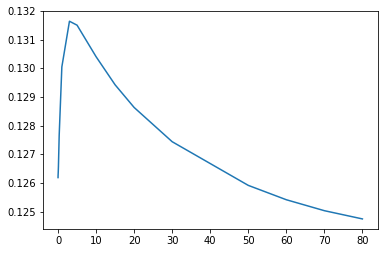

In [128]:
plt.plot(r_alphas,scores)

#### RidgeCV自动筛选参数

In [135]:
r_alphas2=np.logspace(-10,2.8,150)

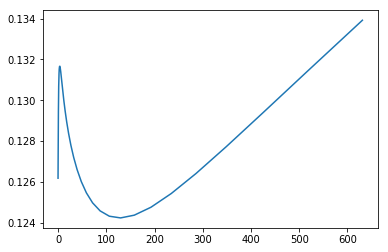

In [138]:
plt.plot(r_alphas2,scores)

可以使用自动优化筛选出最优的alpha

In [140]:
benchmark1(ridge_model2,X_test,y_test)

RMSE: 26002.568196719007
LRMSE: 0.12660125085842427


0.12660125085842427

In [141]:
#最好的alpha
ridge_model2.steps[1][1].alpha_

39.56538865832277

### Lasso Regression

In [142]:
from sklearn.linear_model import LassoCV

In [143]:
l_alphas=np.logspace(-10,2.8,150)

In [146]:
def lasso_train_test(alpha):
    lasso_model=make_pipeline(RobustScaler(),LassoCV(alphas=[alpha],cv=kfolds))
    lasso_model.fit(X_train,y_train)
    lrmse=benchmark1(lasso_model,X_test,y_test)
    return lrmse

In [158]:
import warnings 
warnings.filterwarnings('ignore')

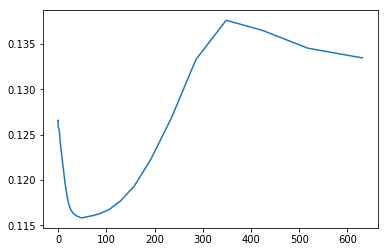

In [148]:
plt.plot(l_alphas,scores)

In [149]:
lasso_train_test(50)

RMSE: 24605.58985079599
LRMSE: 0.11581401793926524


0.11581401793926524

In [159]:
benchmark1(lasso_model2,X_test,y_test)

RMSE: 25439.746569821087
LRMSE: 0.12228974592716889


0.12228974592716889

In [160]:
lasso_model2.steps[1][1].alpha_

192.5589718453296

In [163]:
#lasso_model2.steps[1][1].alpha_

### ElasticNet

In [164]:
from sklearn.linear_model import ElasticNetCV

In [166]:
e_l1ratio=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.85,0.9,0.95,1]

In [167]:
e_alphas=l_alphas

In [169]:
def elastic_train_test(alpha,l1ratio):
    e_model=make_pipeline(RobustScaler(),ElasticNetCV(alphas=[alpha],l1_ratio=[l1ratio]))
    e_model.fit(X_train,y_train)
    lrmse=benchmark1(e_model,X_test,y_test)
    return lrmse

In [170]:
elastic_train_test(50,0.5)

RMSE: 64802.77270461465
LRMSE: 0.3056722083417286


0.3056722083417286

In [171]:
elastic_model3=make_pipeline(RobustScaler(),ElasticNetCV(alphas=e_alphas,l1_ratio=e_l1ratio)).fit(X_train,y_train)

In [172]:
benchmark1(elastic_model3,X_test,y_test)

RMSE: 25439.746569821087
LRMSE: 0.12228974592716889


0.12228974592716889

In [174]:
elastic_model3.steps[1][1].alpha_

192.5589718453296

In [176]:
elastic_model3.steps[1][1].l1_ratio_

1.0

### XGBoost训练

In [177]:
import xgboost as xgb

In [178]:
xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3400,subsample=0.7,nthread=6,seed=123)

In [179]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3400,
       n_jobs=1, nthread=6, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.7)

In [181]:
benchmark1(xg_reg,X_test,y_test)

RMSE: 22846.511574332115
LRMSE: 0.10161079353136271


0.10161079353136271

### Stacking集成算法

#### 底层算法

In [191]:
from mlxtend.regressor import StackingCVRegressor

In [184]:
alphas_alt=np.logspace(-10,2.8,150)

In [185]:
ridge=make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt,cv=kfolds))

In [188]:
lasso=make_pipeline(RobustScaler(),LassoCV(alphas=alphas_alt,cv=kfolds))

In [189]:
elasticnet=make_pipeline(RobustScaler(),ElasticNetCV(alphas=e_alphas,cv=kfolds,l1_ratio=e_l1ratio))

In [190]:
xgboost=make_pipeline(RobustScaler(),xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3460,subsample=0.7,reg_alpha=0.00006,gamma=0,nthread=6,scale_pos_weight=1,seed=27))

#### 上层算法

In [192]:
stack_alg=StackingCVRegressor(regressors=(ridge,lasso,elasticnet,xgboost),meta_regressor=xgboost)

In [193]:
stackX=np.array(X_train)

In [194]:
stacky=np.array(y_train)

In [196]:
stack_alg.fit(stackX,stacky)

StackingCVRegressor(cv=5,
          meta_regressor=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_de...    reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.7))]),
          refit=True,
          regressors=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([1.00000e-10, 1.21873e-10, ..., 5.17719e+02, 6.30957e+02]),
    cv=KFold(n_splits=10, random_state=123...  reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.7))])),
          shuffle=True, store_train_meta_features=False,
          use_features

In [199]:
p

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [200]:
benchmark1(stack_alg,X_test,y_test)

RMSE: 22251.381642116565
LRMSE: 0.10578249817750969


0.10578249817750969